In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier as NN

import math
import matplotlib as mpl
from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
from scipy.sparse import csr_matrix, csgraph, csr_array


In [2]:
# To read session file that is computed in another OS system but load in linux system
# We need to change the pathlib
import platform
import pathlib
plt = platform.system()
if plt == 'Linux': pathlib.WindowsPath = pathlib.PosixPath

In [15]:
import dill
# to save the current session, uncomment the next line
# dill.dump_session("mnist_graph_construction.db")

# Load the previous session
# dill.load_session("utils/mnist_graph_construction.db")


In [16]:
# import pickle
# # Store individual objects (save them in sequential order)
# with open("inter_data.pickle", "wb") as inter_data_file:
#     pickle.dump(X, inter_data_file)
#     pickle.dump(y, inter_data_file)

# # Load individual objects (the order is the same as how they are stored)
# with open("inter_data.pickle", "rb") as inter_data_file:
#     pickled_X = pickle.load(inter_data_file)
#     pickled_y = pickle.load(inter_data_file)

In [10]:
import numba
from numba import jit

In [3]:
# Load the dataset
# https://www.python-course.eu/neural_network_mnist.php
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "utils/mnist_data/mnist_train.csv"
# train_data = np.loadtxt(data_path, delimiter=",")
# fac = 0.99 / 255
# train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
# train_ilabels = np.asfarray(train_data[:, :1]).ravel()

train_data = pd.read_csv(data_path, 
                        delimiter=",", header=None, dtype=np.uint8)
# train_imgs = train_data.iloc[:, 1:]/255   # divide by 255 only for model prediction
train_imgs = train_data.iloc[:, 1:]
train_labels = np.asarray(train_data.iloc[:, :1][0])


In [4]:
# subsample the original dataset, each digit has 1000 instances rather than 5000-6000
all_indices = []
for digit in np.arange(0,10):
    single_digit_indices = set(np.where(train_labels == digit)[0][:1000])
    all_indices = set(all_indices).union(single_digit_indices)
print(len(all_indices))

X = train_imgs.iloc[list(all_indices), :]
y = train_labels[list(all_indices)]


10000


In [12]:
def inv_log(x):
    return -np.log(x)

def get_edges(kernel):
    edges = []

    n_samples = kernel.shape[0]
    for i in range(n_samples):
        for j in range(i):
            weight = kernel[i, j]
            if weight != 0 :
                edges.append([i, j, weight])
    return edges


def get_weights(X, 
                density_scorer, 
                # mode,
                weight_func = inv_log):
    epsilon = 1
    n_samples, _ = X.shape
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(i):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            if dist <= epsilon:
                midpoint = (v0 + v1)/2
                density = density_scorer(midpoint.reshape(1, -1))
                # if mode == 1:
                k[i, j] = weight_func(np.exp(density)) * dist
                # else:
                #     k[i, j] = weight_func(sigmoid(density)) * dist
            # else:
            #     k[i, j] = 0
            # k[j, i] = k[i, j]
    return k

@jit(nopython=True)
def calculate_weighted_distance(v0, v1, penalty_term = 2):
    diff = np.subtract(v0, v1)
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    alpha=0.10,
    weight_func = inv_log
    ):
    n_samples, n_ftrs = X.shape
    
    k = np.zeros((n_samples, n_samples))
    W = k
    X = X.to_numpy()

    for i in tqdm(range(n_samples)):
        # v0 = csr_array(X.iloc[i])
        # v0 = X.iloc[i].values.reshape(-1, 1)
        v0 = X[i]
        for j in range(n_samples):
            # v1 = csr_array(X.iloc[j])
            # v1 = X.iloc[j].values.reshape(-1, 1)
            v1 = X[j]
            # modify the distance function so that removing pixels incurring larger cost.
            dist = calculate_weighted_distance(v1, v0, penalty_term=1.1)
            # dist = np.linalg.norm(v0 - v1)
            k[i, j] = dist
            if dist != 0:
                W[i,j] = weight_func(dist)
        
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        k[i, mask] = 0
        W[i, mask] = 0
        
#     for i in range(n_samples):
#         v0 = X[i, :].reshape(-1, 1)
#         for j in range(n_samples):
#             v1 = X[j, :].reshape(-1, 1)
#             if k[i, j] != 0:
#                 current_value = k[i, j]
# #                 k[i, j] = current_value**alpha
#                 k[i, j] = weight_func(current_value)
    return W

def get_weights_e(X, 
                 epsilon = 0.75,
                 alpha=0.10,
                 weight_func = inv_log):
    n_samples, n_ftrs = X.shape
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(i):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            if dist <= epsilon:
                k[i, j] = weight_func(current_value)
                k[j, i] = k[i, j]
    return k

In [20]:
clf = NN(max_iter=5000).fit(X/255, y)

In [21]:
predictions = clf.predict_proba(X/255)

In [22]:
# bandwidths = 10 ** np.linspace(-2, 0, 10)
# grid = GridSearchCV(
#     KernelDensity(kernel='gaussian'),
#     {'bandwidth': bandwidth},
# )

# grid.fit(X)
# kde = grid.best_estimator_

# define the kernel density function after grid search
# bandwidth = 10 ** (-2 + 2/9*5)
# kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
# kde.fit(X)
# print(kde.get_params())


In [13]:
def construct_graph(weight_matrix):
    graph = csr_matrix(weight_matrix)
    return graph

def find_shortest_path(graph, start_point_idx):
    dist_matrix, predecessors = csgraph.dijkstra(
        csgraph=graph, directed=True, indices=start_point_idx, return_predecessors=True
    )
    return dist_matrix, predecessors

def reconstruct_shortest_path(predecessors, start_point_idx, end_point_idx):
    """Get all the nodes along the path between the start point and the end point. 

    Args:
        predecessors (matrix of shape (1, n_nodes)): contain the previous node in the path.
        start_point_idx (int): the index of the start data point
        end_point_idx (int): the index of the end data point

    Returns:
        node_path (list): [start_point_idx, intermedium points index, end_point_idx]
    """
    if predecessors[end_point_idx] == start_point_idx:
        node_path = [end_point_idx]
    else:
        node_path = []
    intermedium_idx = end_point_idx
    while (predecessors[intermedium_idx] != start_point_idx):
        node_path.append(intermedium_idx)
        intermedium_idx = predecessors[intermedium_idx]
    if intermedium_idx != node_path[-1]:
        node_path.append(intermedium_idx)
    node_path.append(start_point_idx)
    
    return node_path[::-1]
 
def build_symmetric_matrix(kernel):
    for i in range(kernel.shape[0]):
        for j in range(i):
            kernel[j, i] = kernel[i,j]
    return kernel

def build_asymmetric_matrix(kernel, X, weight_func):
    n_samples = kernel.shape[0]
    X = X.to_numpy()
    for i in tqdm(range(n_samples)):
        for j in range(n_samples):
            if kernel[i,j] != 0:
                v0 = X[0]
                v1 = X[1]
                # v0 = X.iloc[i].values.reshape(-1, 1)
                # v1 = X.iloc[j].values.reshape(-1, 1)
                dist = calculate_weighted_distance(v0, v1, penalty_term=1.1)
                kernel[j, i] = weight_func(dist)
    return kernel

In [14]:
n_neighbours = 20
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(1)
r = (n_neighbours / (n_samples * volume_sphere))

# Construct the global weighted graph.
# Kernel is asymmetric if using KNN to get weight, and OG only keeps the bottom left half of the matrix
weight_func=lambda x: -x*np.log(r/x)  # x**alpha
kernel = get_weights_kNN(
            X,
            n_neighbours=int(n_neighbours),
            weight_func=weight_func
        )

# sym_kernel = build_symmetric_matrix(kernel)
# asym_kernel = build_asymmetric_matrix(kernel, X, weight_func)

# Replace FOR with parallel FOR (multi-processors emia..)
# On local laptop, set the number of processors to 2
# On server, set the number of processors to #of available - 1 


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\s3964913\AppData\Local\Temp\ipykernel_20268\2808853557.py:43: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  reweight_vector = np.where(diff>=0, 1, -penalty_term)
  2%|▏         | 200/10000 [00:15<12:28, 13.09it/s]


KeyboardInterrupt: 

In [ ]:
asym_kernel = build_asymmetric_matrix(kernel, X, weight_func)

dill.dump_session("mnist_graph_construction.db")

In [ ]:
# graph = Graph()
# edges = get_edges(kernel)
# for edge in tqdm(edges):
#     graph.add_edge(*edge) 

In [67]:
def get_minimum_dist(dist_matrix):
    """get the shortest distance and its data index
    Args:
        dist_matrix (array): shape: 1 x n_nodes

    Returns:
        min_dist: minimum distance in the distance matrix
        min_dist_idx: index of the data point with the shortest dist
    """
    min_dist = np.min(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False)) 
    min_dist_idx = np.argmin(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False))
    return min_dist, min_dist_idx

def get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths = 1, pred_threshold=0.55):
    assert num_paths > 0 and isinstance(num_paths, int), "only positive integers"
    end_point_idx = []
    path_count = 0
    for idx in np.argsort(np.ma.masked_where(dist_matrix==0, dist_matrix)):
        if (y[idx] == target_class and
        predictions[idx, class_labels.index(target_class)] >= pred_threshold): 
            end_point_idx.append(idx)
            if path_count >= num_paths-1:
                break
            else:
                path_count += 1
    return end_point_idx

def get_user_agency(sp_graph, start_point_idx, alternative_classes, predictions, y, class_labels, pred_threshold=0.55):
    dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx)
    alt_class_dict = {}
    alt_path_dict = {}
    for alt_class in alternative_classes:
        alt_end_idx = get_closest_cf_point(dist_matrix, predictions, y, alt_class, class_labels, pred_threshold = pred_threshold)
        alt_end_dist = dist_matrix[alt_end_idx[0]]
        alt_class_dict[alt_class] = {alt_end_idx[0]: alt_end_dist}
        
        alt_end_path = reconstruct_shortest_path(predecessors, start_point_idx, alt_end_idx[0])
        alt_path_dict[alt_class] = {alt_end_idx[0]: alt_end_path}
    
    return alt_class_dict, alt_path_dict

In [ ]:
def get_all_paths_agency():
    pass

In [58]:
np.where(y==1)[0][:10]

array([ 2,  5,  6,  8, 16, 17, 27, 42, 47, 50], dtype=int64)

In [49]:
sp_graph = construct_graph(asym_kernel)
start_point_idx = 2
target_class = 9
class_labels = list(map(int, clf.classes_))
alternative_classes = list(set(class_labels) - set([target_class, y[start_point_idx]]))
res = {}
res[start_point_idx] = {}

dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)

end_point_indices = get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths=20)
print(end_point_indices)

for order, end_point_idx in enumerate(end_point_indices):
    shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
    # print()
    for node_idx in shortest_path[:-1]:
        alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
        alt_class_dict, alt_path_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
        # print("node index: ", node_idx)
        # print(alt_class_dict)

        res[start_point_idx][order] = shortest_path
print(res)

[2503, 5133, 466, 5229, 2563, 2123, 1051, 1039, 422, 1137, 5891, 3898, 5207, 366, 2504, 2391, 385, 2581, 626, 3740]
{2: {0: [2, 486, 2503], 1: [2, 16, 5815, 5133], 2: [2, 4103, 1077, 466], 3: [2, 5798, 748, 5229], 4: [2, 5292, 1726, 2563], 5: [2, 2928, 5165, 2123], 6: [2, 16, 5815, 5133, 1051], 7: [2, 416, 2952, 1112, 1039], 8: [2, 16, 5815, 5133, 422], 9: [2, 416, 2952, 1112, 1137], 10: [2, 16, 5815, 5133, 5891], 11: [2, 2946, 2898, 3898], 12: [2, 416, 1093, 2460, 5207], 13: [2, 16, 5815, 5133, 366], 14: [2, 16, 5815, 2458, 2504], 15: [2, 5292, 1462, 5073, 2636, 2391], 16: [2, 16, 1145, 5988, 385], 17: [2, 16, 5815, 2458, 2581], 18: [2, 5292, 1462, 5100, 3977, 626], 19: [2, 4103, 1077, 466, 3740]}}


In [ ]:
dill.dump_session("mnist_graph_construction.db")

In [ ]:
def plot_digits(path, _id):
    n_digits = len(path)
    ncols=min(10, n_digits)
    nrows = math.ceil(n_digits / ncols)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
    axes = axes.ravel()
    for idx, img_idx in enumerate(path):
        ax = axes[idx]
        image = np.array(X.iloc[img_idx, :])
        label = y[img_idx]
        ax.set_axis_off()
        ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f"id:{_id}, t: {label}")
    # plt.savefig(f'example_{_id}_log.pdf', dpi=300)

def print_alt_paths(alt_path_dict):
    for alt_class, alt_class_path in alt_path_dict.items():
        plot_digits(list(alt_class_path.items())[0][1], '-'.join(map(str, [alt_class, 0])))

node index:  2
{0: {1088: 153.36609466742624}, 2: {6034: 68.99109024824892}, 4: {44: 61.24142130574533}, 7: {4364: 57.38998932973475}, 8: {6772: 73.14110766884947}}
{0: {1088: [2, 5292, 3342, 4875, 5025, 1088]}, 2: {6034: [2, 2874, 6034]}, 4: {44: [2, 16, 44]}, 7: {4364: [2, 4364]}, 8: {6772: [2, 2408, 6772]}}
node index:  16
{0: {6466: 144.2724164738749}, 2: {2226: 67.54503585100791}, 4: {44: 48.741752057600024}, 7: {1850: 49.25593903366071}, 8: {6704: 70.3800658408136}}
{0: {6466: [16, 5506, 1423, 6466]}, 2: {2226: [16, 2928, 2226]}, 4: {44: [16, 44]}, 7: {1850: [16, 1850]}, 8: {6704: [16, 764, 6704]}}
node index:  5815
{0: {1999: 165.36534962967193}, 2: {2847: 48.85662400522374}, 4: {3000: 44.17538103213447}, 7: {5165: 37.50616223025132}, 8: {621: 53.71259219467313}}
{0: {1999: [5815, 5129, 441, 1999]}, 2: {2847: [5815, 2847]}, 4: {3000: [5815, 3000]}, 7: {5165: [5815, 5165]}, 8: {621: [5815, 621]}}
node index:  2458
{0: {5141: 141.71812567002414}, 1: {748: 44.71436341584624}, 2: {2

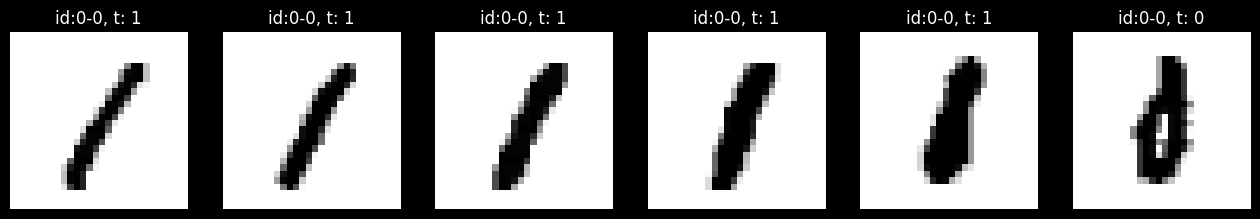

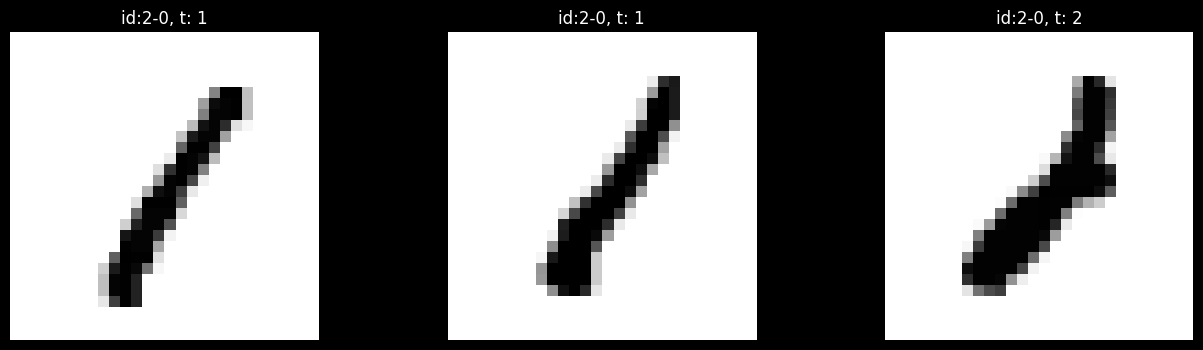

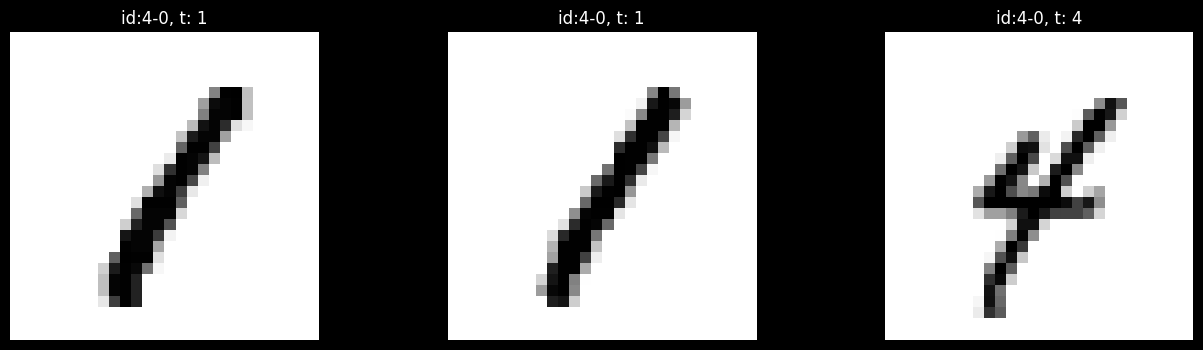

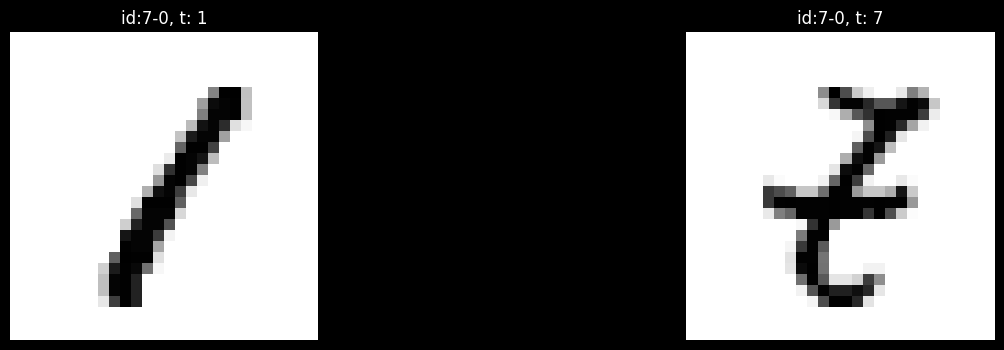

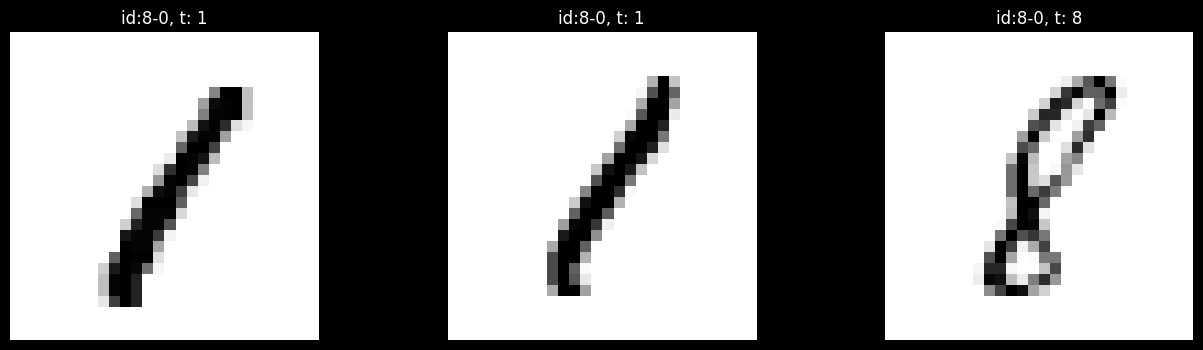

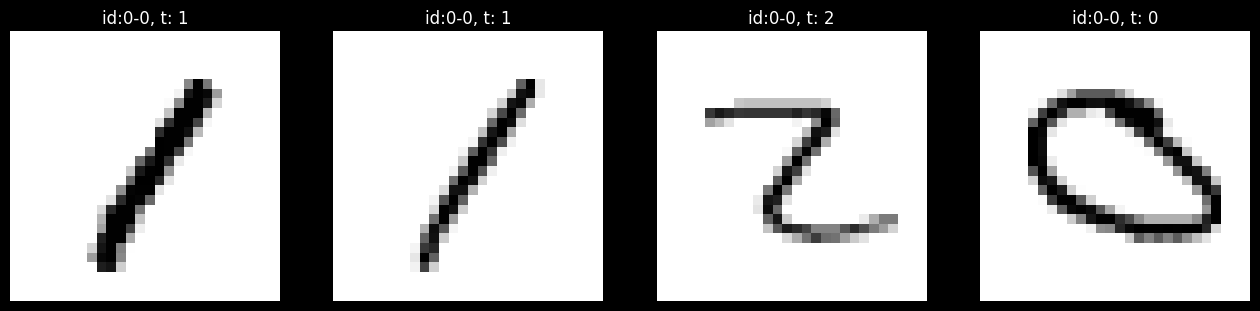

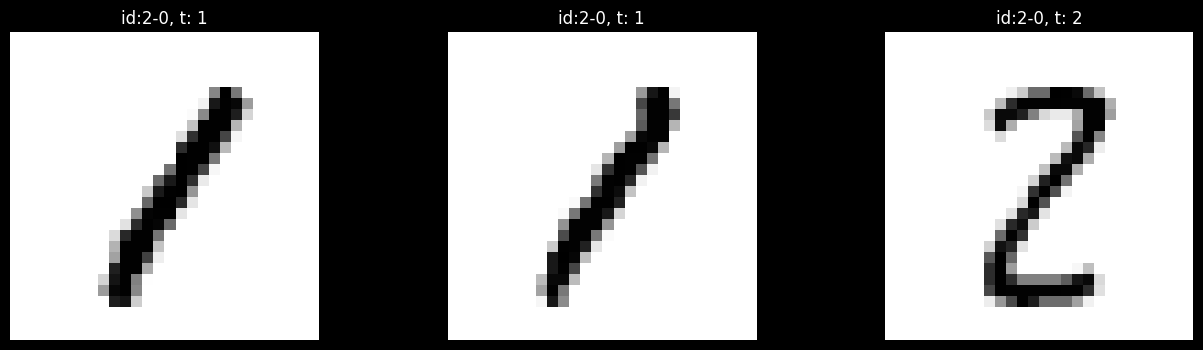

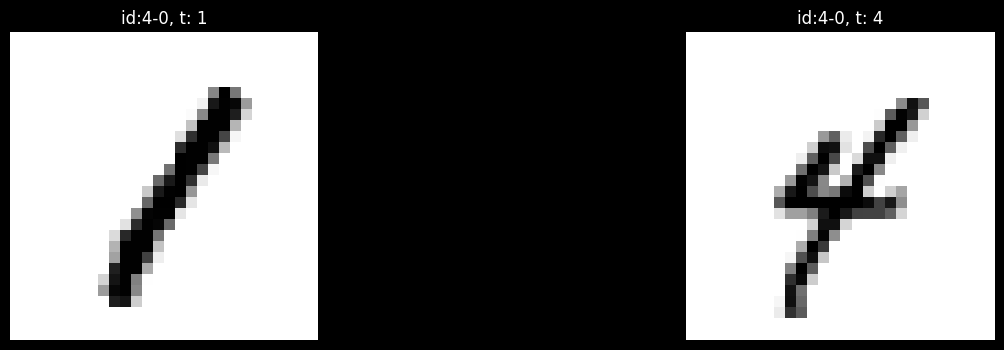

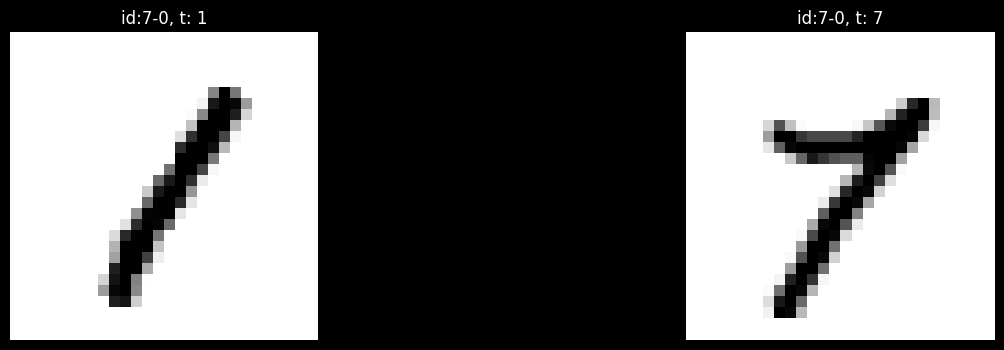

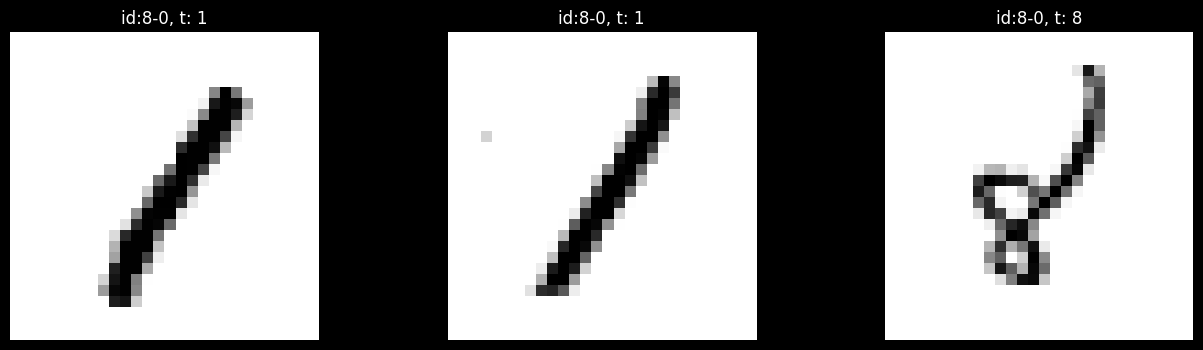

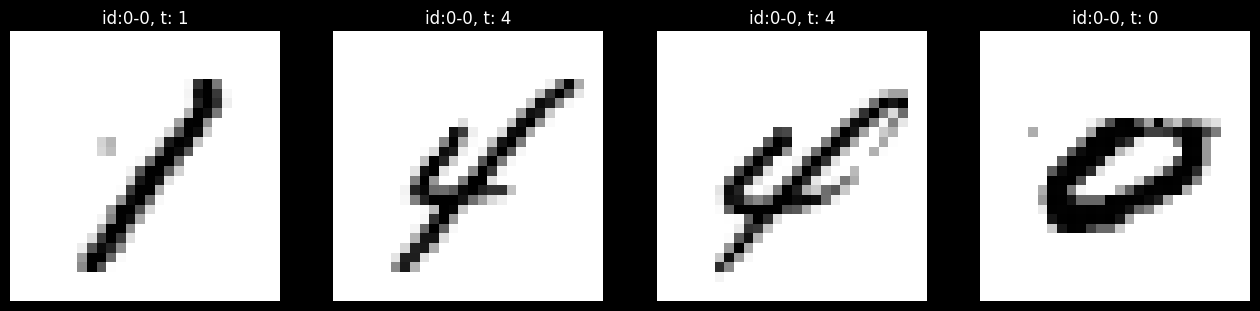

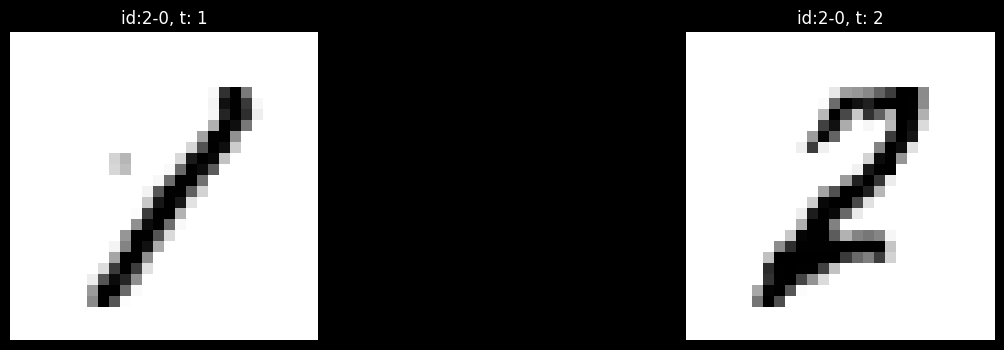

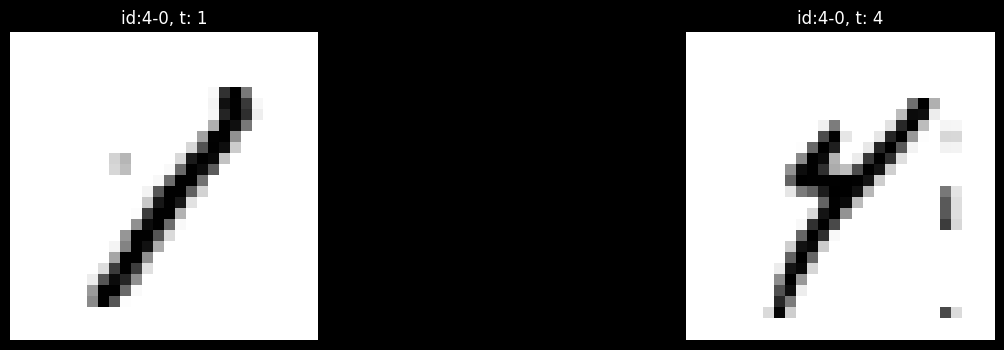

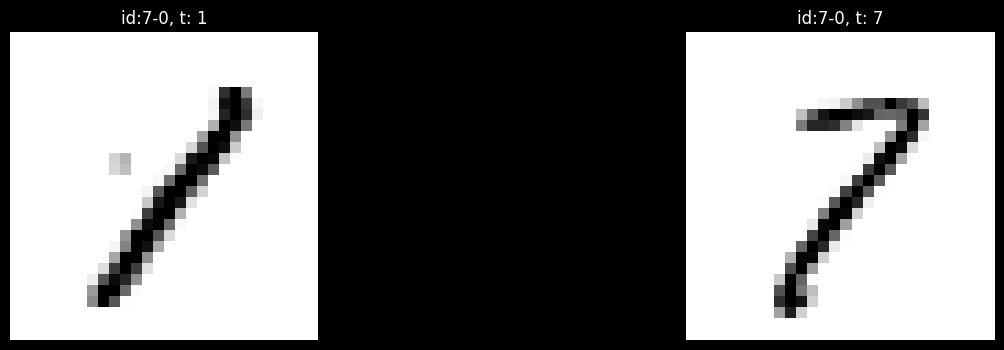

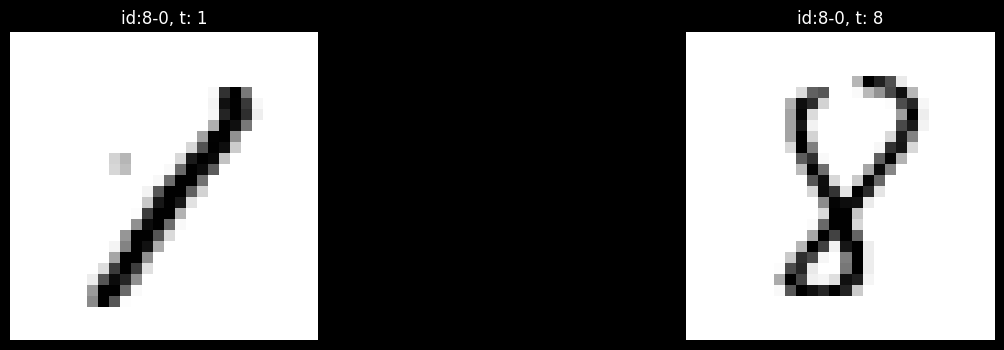

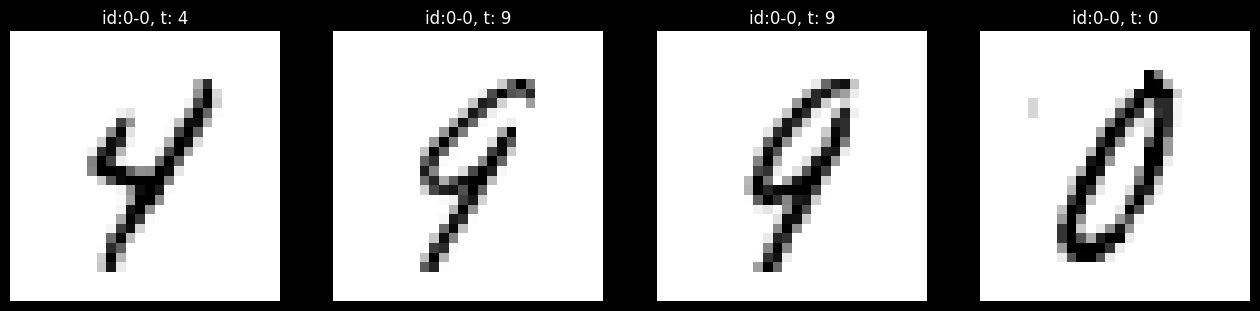

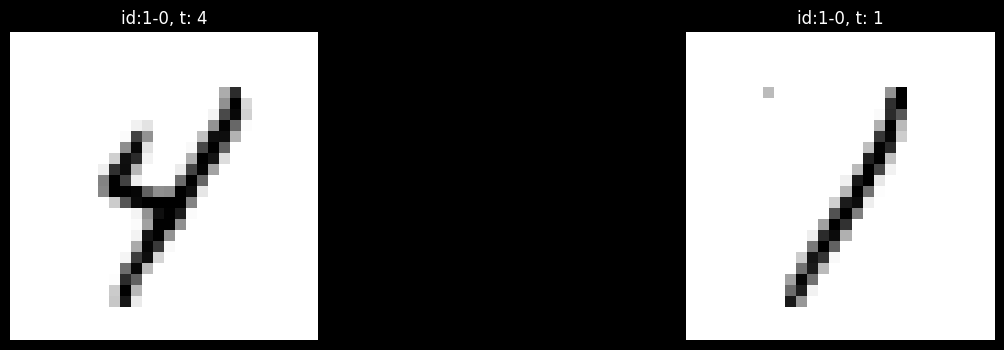

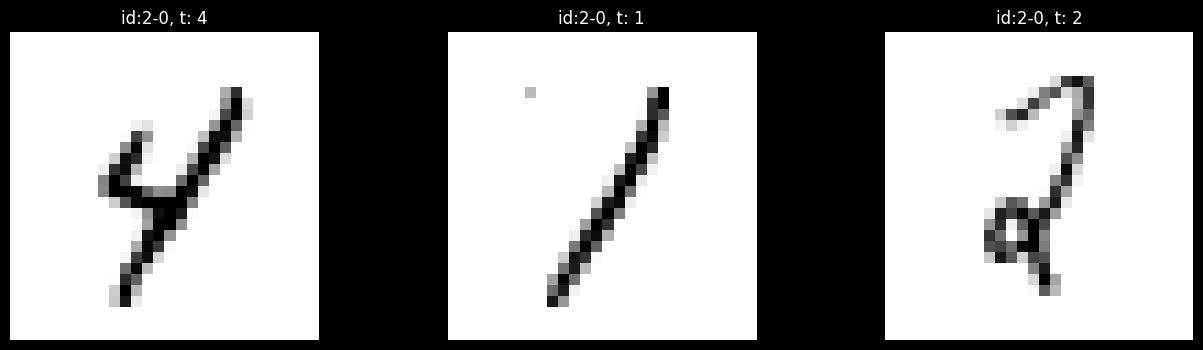

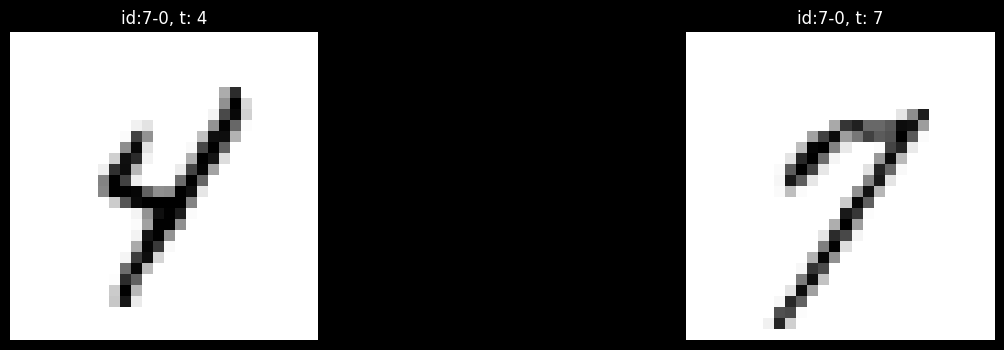

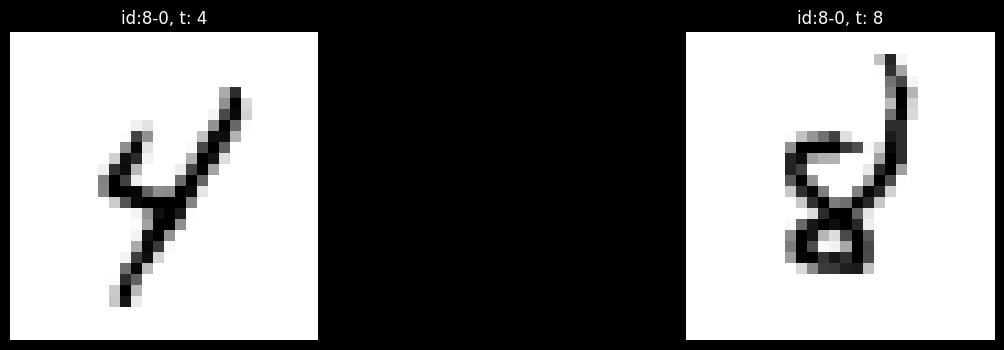

In [83]:
#4
shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=2581)
# print(shortest_path)
for node_idx in shortest_path[:-1]:
    alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
    alt_class_dict, alt_path_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
    print("node index: ", node_idx)
    print(alt_class_dict)
    print(alt_path_dict)
    print_alt_paths(alt_path_dict)

# 2, 16, 5815, 2458, 2581

node index:  2
{0: {1088: 153.36609466742624}, 2: {6034: 68.99109024824892}, 4: {44: 61.24142130574533}, 7: {4364: 57.38998932973475}, 8: {6772: 73.14110766884947}}
{0: {1088: [2, 5292, 3342, 4875, 5025, 1088]}, 2: {6034: [2, 2874, 6034]}, 4: {44: [2, 16, 44]}, 7: {4364: [2, 4364]}, 8: {6772: [2, 2408, 6772]}}
node index:  5292
{0: {1088: 132.58142118994013}, 2: {6034: 82.58089451878175}, 4: {6826: 72.3977710757}, 7: {1324: 57.39978647188613}, 8: {6916: 65.68918189994933}}
{0: {1088: [5292, 3342, 4875, 5025, 1088]}, 2: {6034: [5292, 5962, 252, 6034]}, 4: {6826: [5292, 4103, 6826]}, 7: {1324: [5292, 1462, 1324]}, 8: {6916: [5292, 486, 6916]}}
node index:  1462
{0: {1088: 131.07246211890978}, 2: {427: 64.77328273728226}, 4: {5177: 60.95214041738748}, 7: {1324: 35.36254814192508}, 8: {4019: 62.882617695664464}}
{0: {1088: [1462, 1042, 4875, 5025, 1088]}, 2: {427: [1462, 2233, 427]}, 4: {5177: [1462, 6236, 5177]}, 7: {1324: [1462, 1324]}, 8: {4019: [1462, 6236, 4019]}}
node index:  5100
{0

c:\Users\s3964913\Anaconda3\envs\cf_journey\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


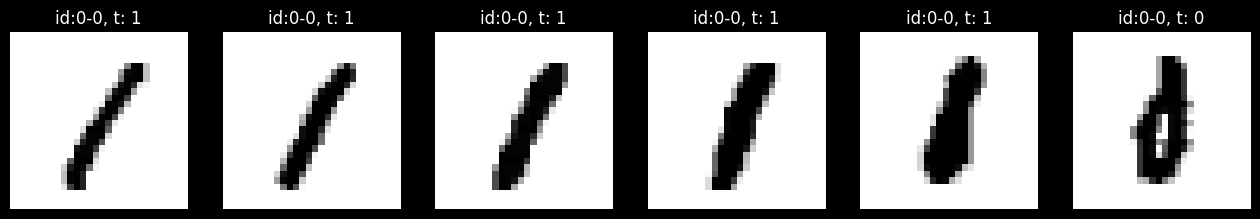

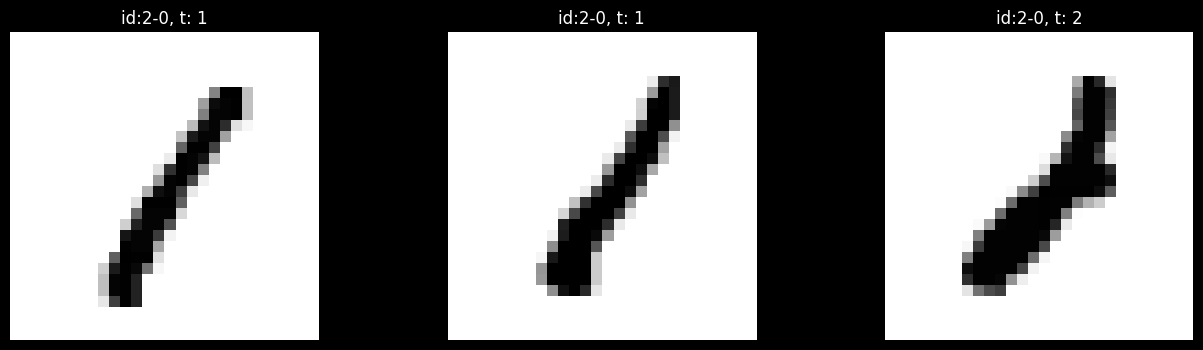

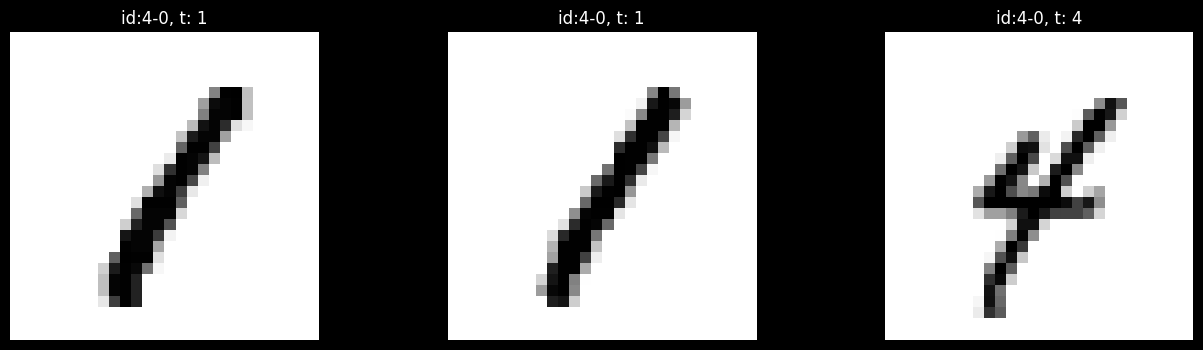

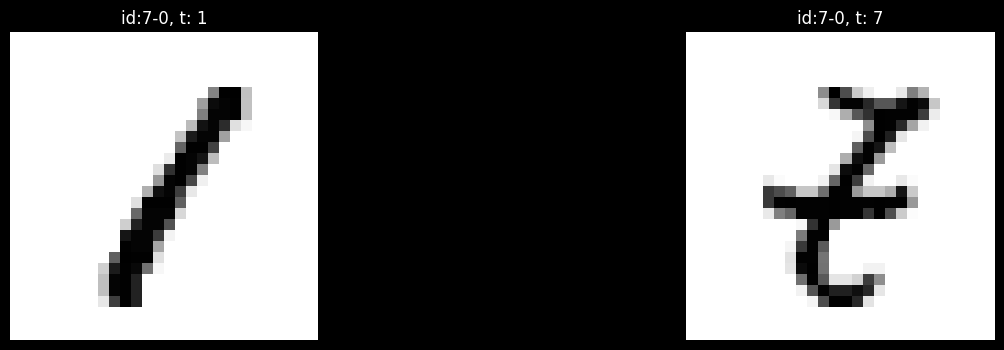

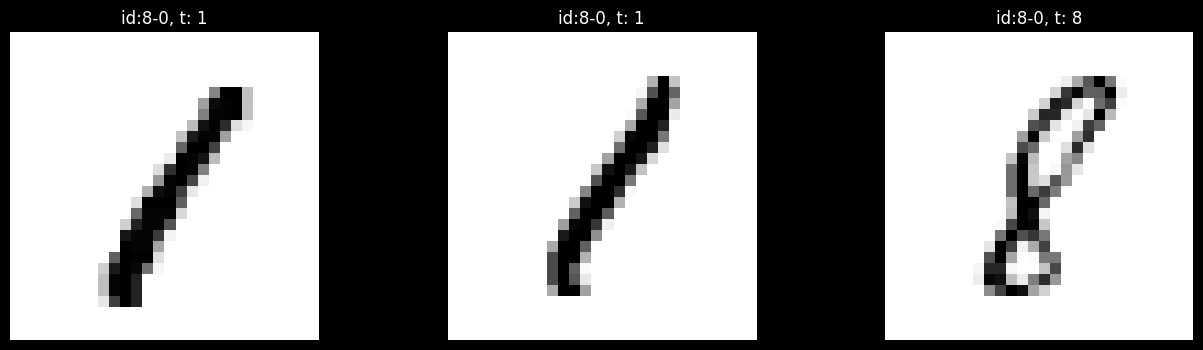

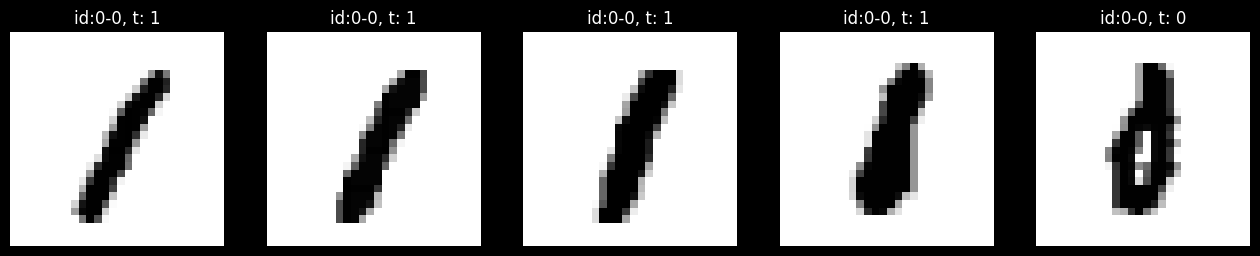

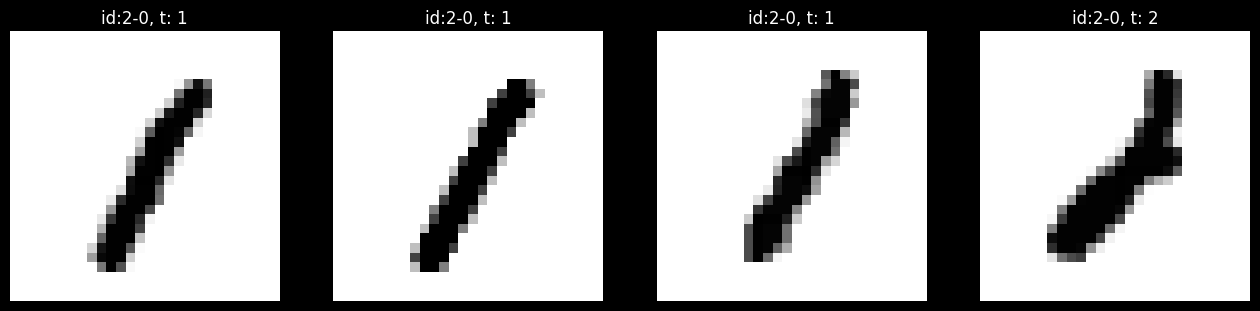

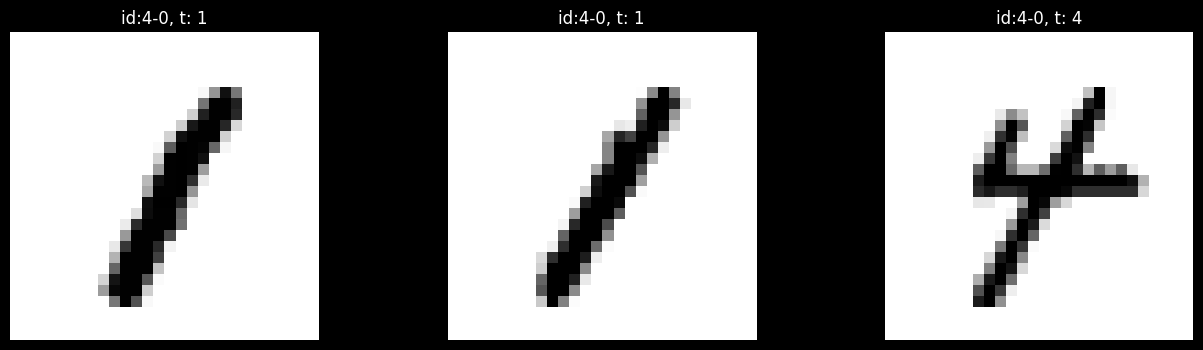

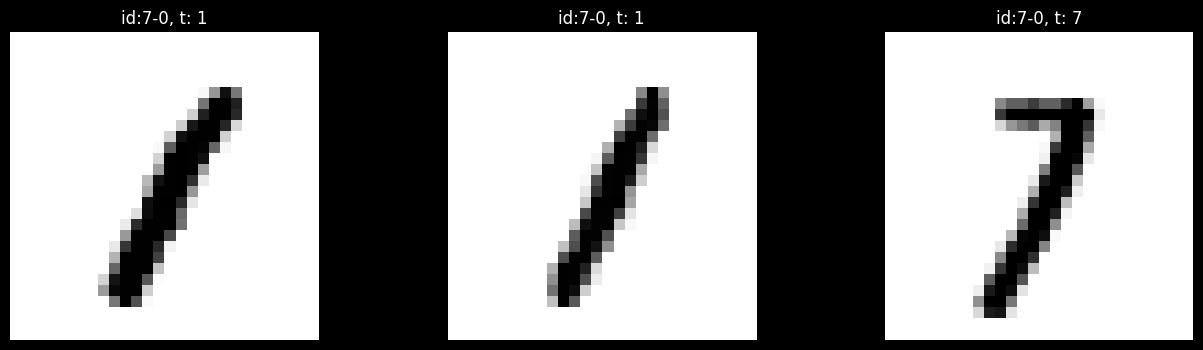

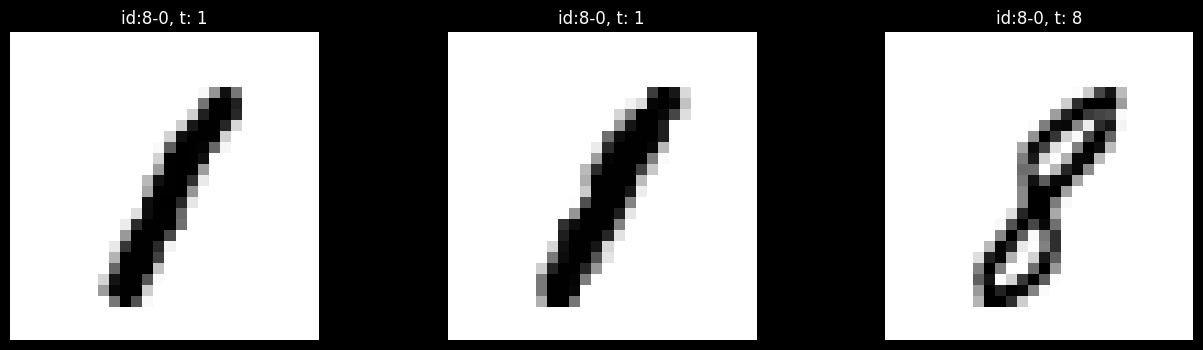

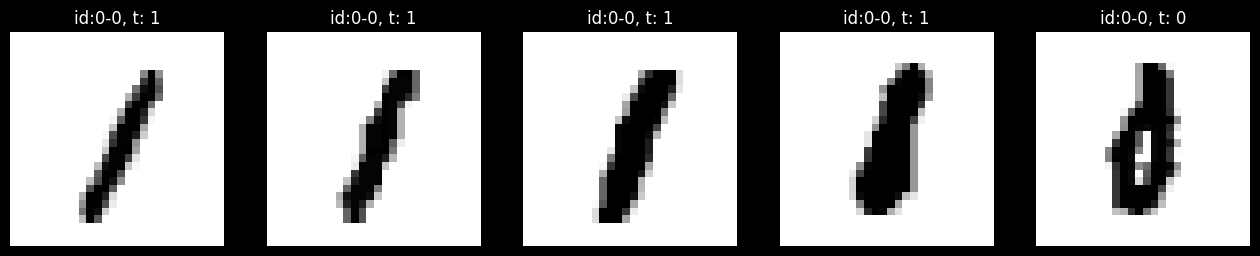

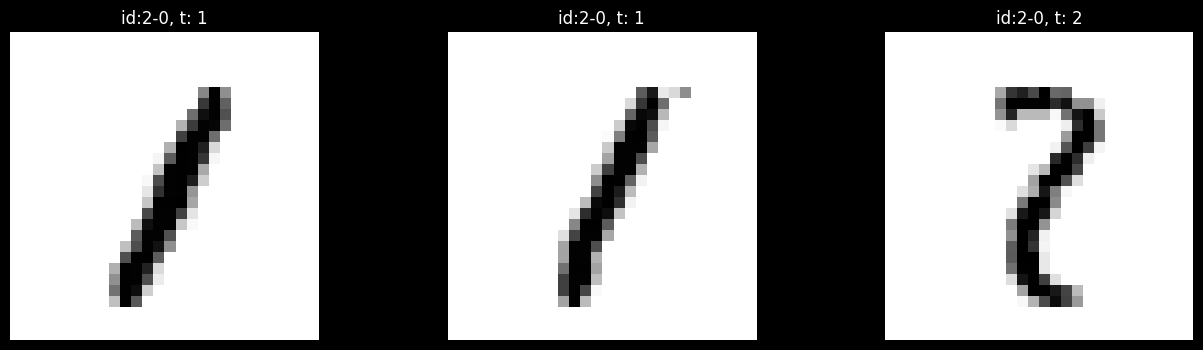

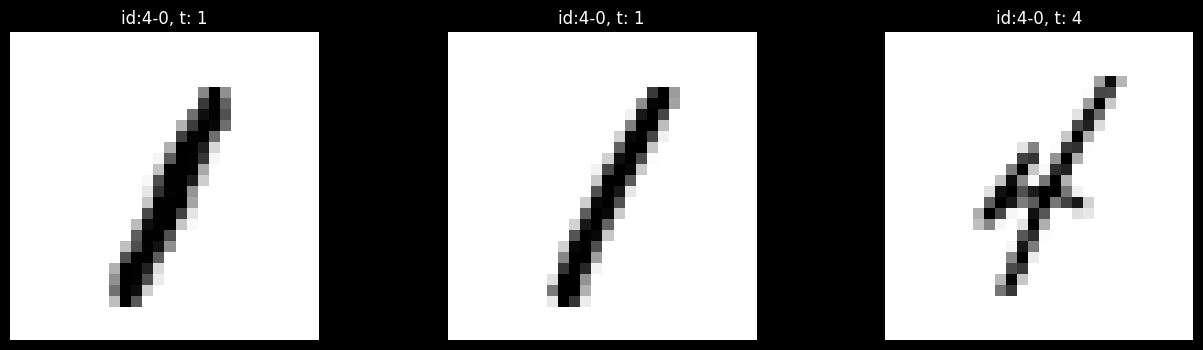

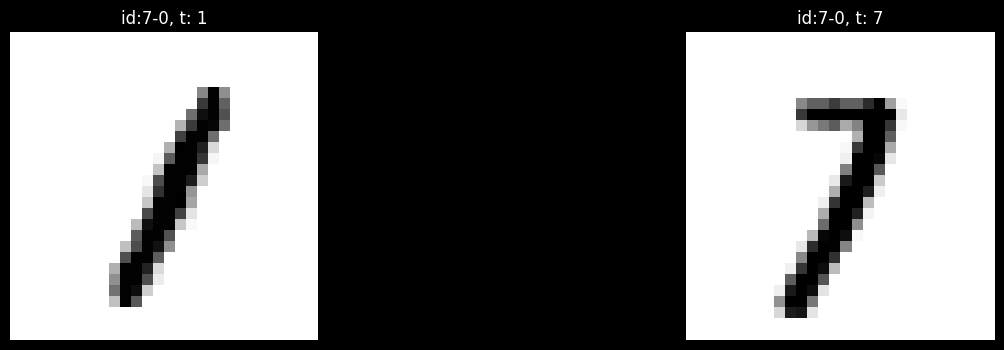

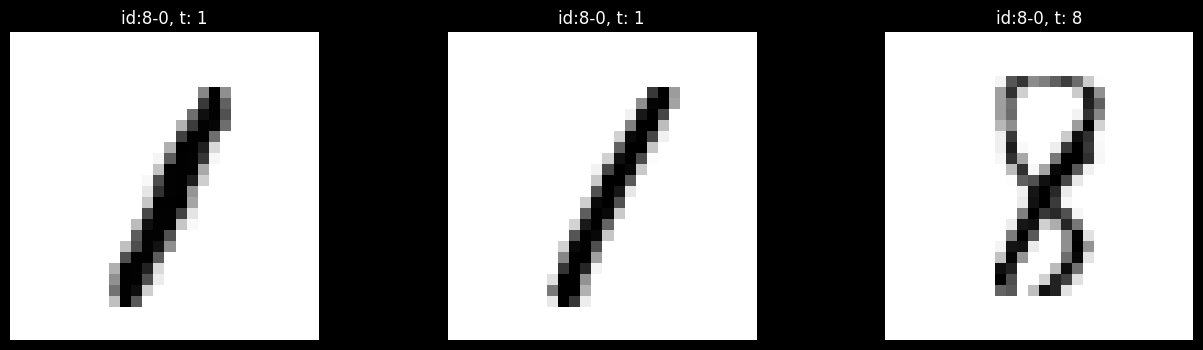

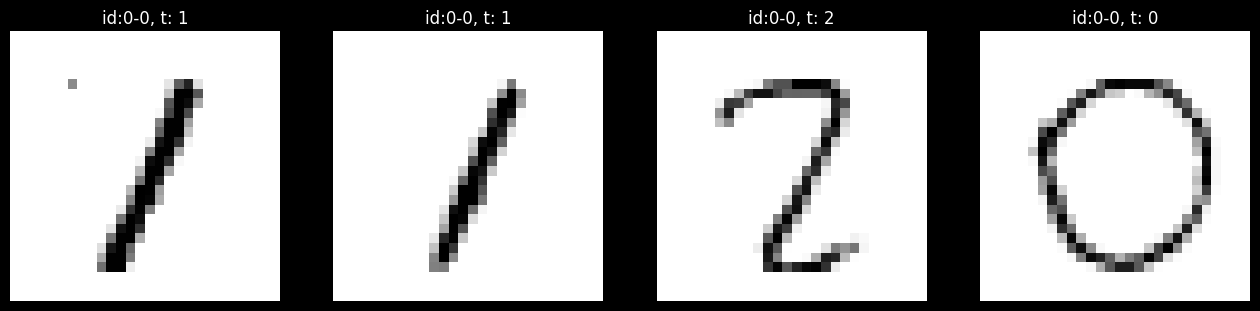

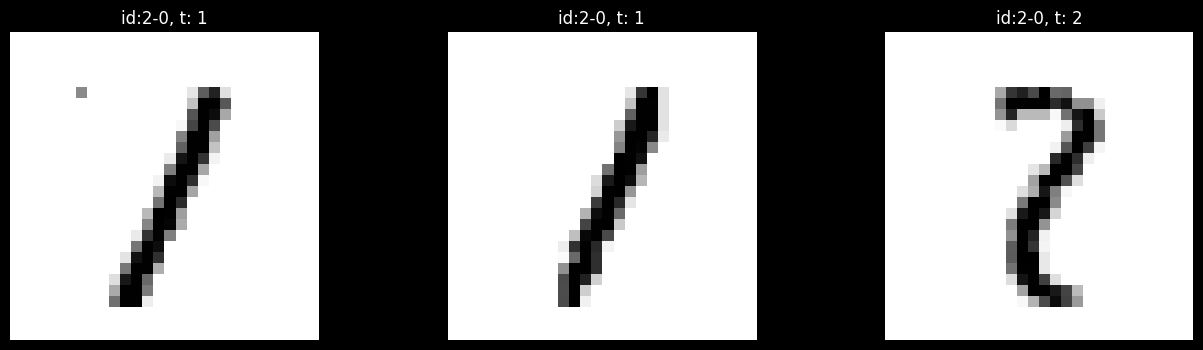

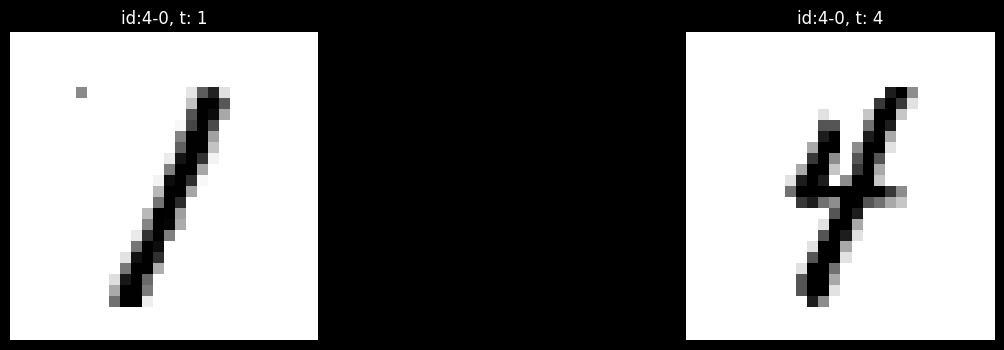

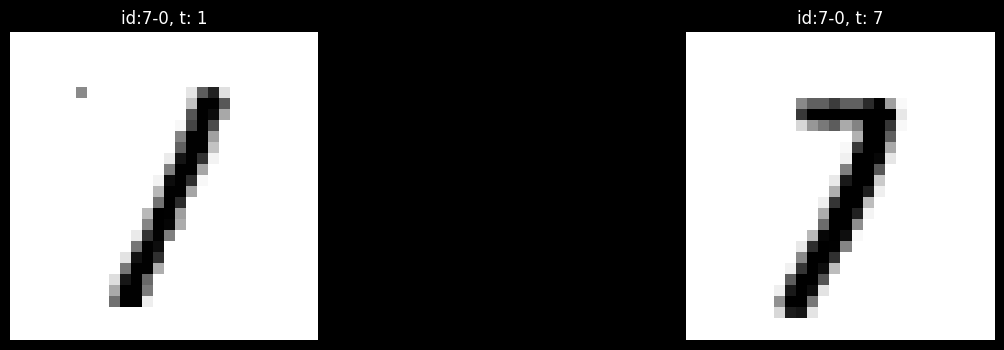

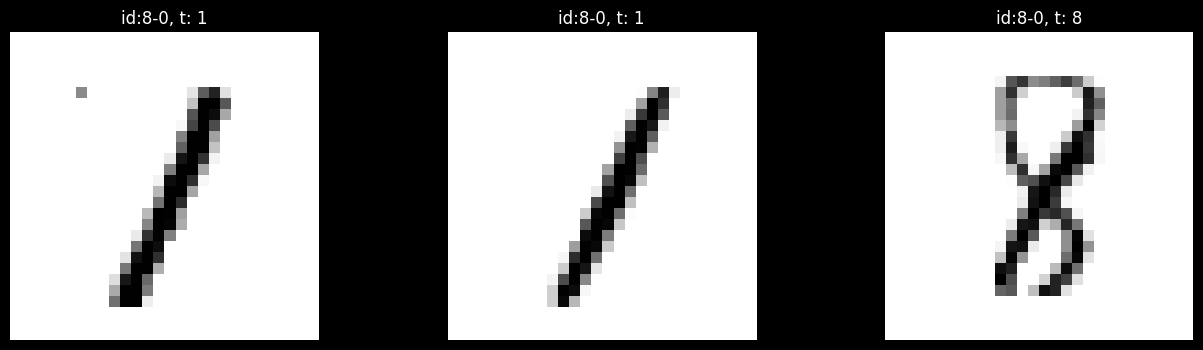

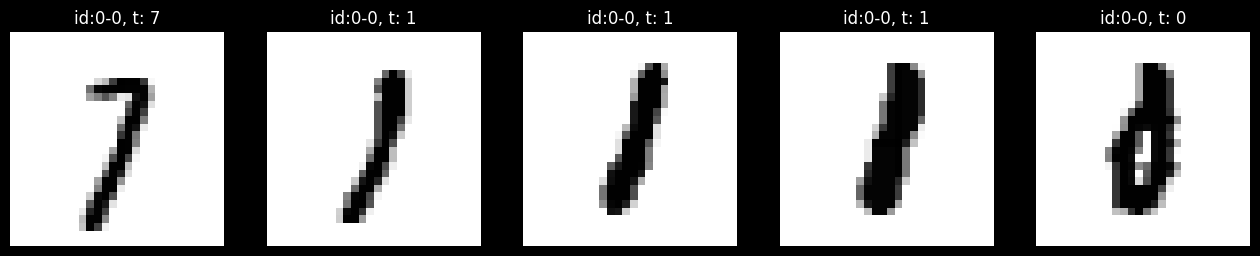

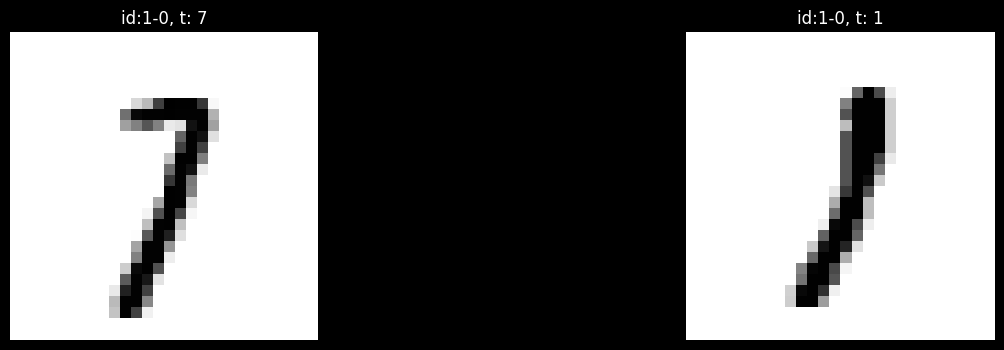

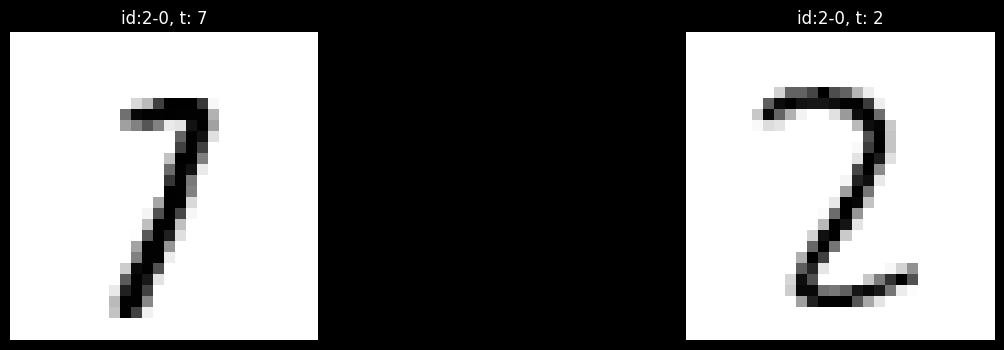

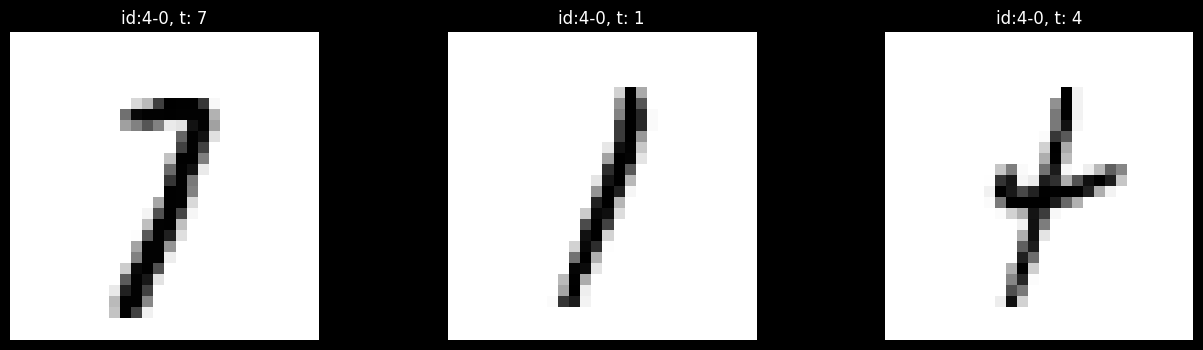

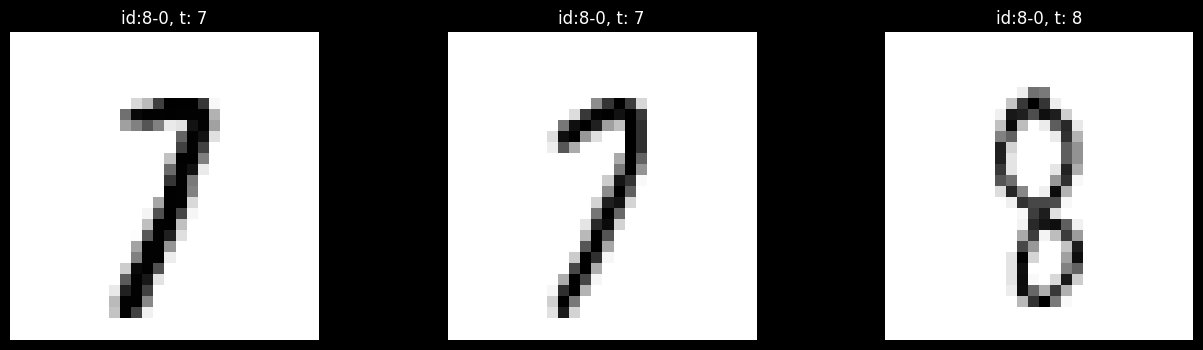

In [85]:
#7
shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=626)
# print()
for node_idx in shortest_path[:-1]:
    alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
    alt_class_dict, alt_path_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
    print("node index: ", node_idx)
    print(alt_class_dict)
    print(alt_path_dict)
    print_alt_paths(alt_path_dict)

# 2, 5292, 1462, 5100, 3977, 626

In [96]:
((144.2724164738749 + 67.54503585100791 + 48.741752057600024 + 49.25593903366071 + 70.3800658408136)/5 + (165.36534962967193 + 48.85662400522374 + 44.17538103213447 + 37.50616223025132 + 53.71259219467313)/5 + (141.71812567002414 + 89.40060904563364 + 44.94051314718127 + 54.54935580826052)/4)/3

76.20480486251908

In [95]:
((132.58142118994013 + 82.58089451878175 + 72.3977710757 + 57.39978647188613 + 65.68918189994933)/5 + (131.07246211890978 + 64.77328273728226 + 60.95214041738748 + 35.36254814192508 + 62.882617695664464)/5 + (138.26143705101362 + 58.99158899293038 + 43.19788111596109 + 33.16903726935579 + 63.32727573402195)/5 + (136.7990841313817 + 51.1152642002417 + 74.67152111632639 + 73.26003875555521)/4)/4

76.12233558425453

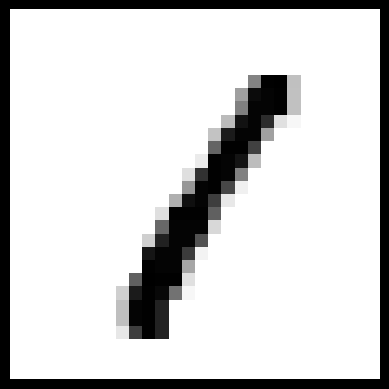

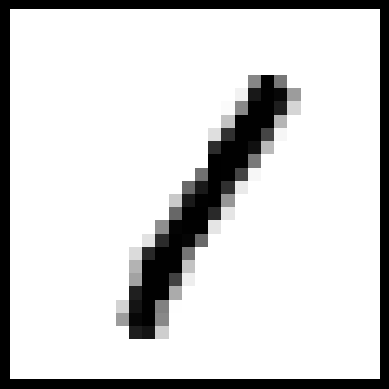

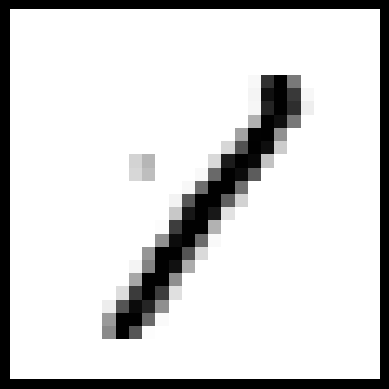

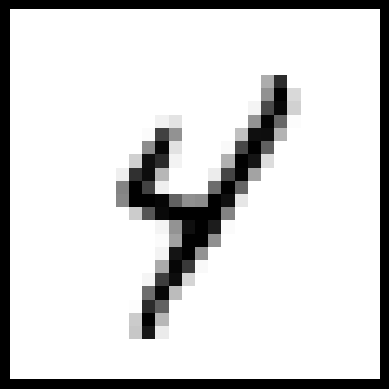

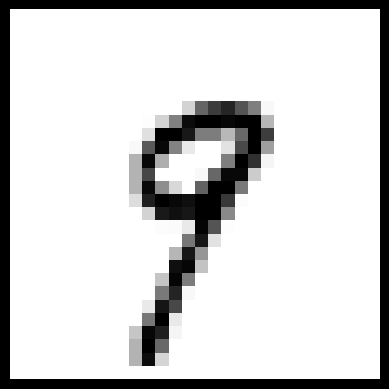

In [94]:
# for k in res.keys():
#     for k2 in res[k].keys():
#         plot_digits(res[k][k2], '-'.join(map(str, [k, k2])))

# 7
img_indices = [2, 5292, 1462, 5100, 3977, 626]
# 4
img_indices = [2, 16, 5815, 2458, 2581]
# alternative paths
# img_indices = [6326, 2019, 2857, 6684]
for img_idx in img_indices:
    digit1 = np.array(X.iloc[img_idx, :])
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(digit1.reshape(28,28), cmap=plt.cm.gray_r, interpolation=None)
    plt.savefig(f'figures/digit_id_{img_idx}.pdf', dpi=300)